In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
np.random.seed(42)

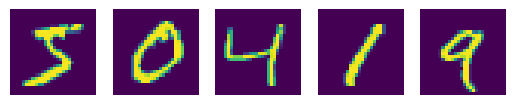

In [2]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

for i in range(5):    
    plt.subplot(1,5,i+1)
    plt.imshow(x_train[i])
    plt.axis('off')

In [4]:
############# Simple VAE Model ###########
############# Simple VAE Model ###########
def sampling(args):
    z_mean, z_sigma = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_sigma) * epsilon

def build_encoder(latent_dim):
    input_image = layers.Input(shape=(28,28,1))
    d = layers.Conv2D(64, 3, strides=2, padding='same', activation = 'relu')(input_image)	    
    d = layers.Conv2D(128, 3, strides=2, padding='same', activation = 'relu')(d)
    d = layers.Conv2D(256, 3, strides=2, padding='same', activation = 'relu')(d)    
    d = layers.Conv2D(512, 3, strides=2, padding='same', activation = 'relu')(d)   
    d = layers.Flatten()(d)
    d = layers.Dense(128, activation='relu')(d)  
    d = layers.Dense(128, activation='relu')(d)
    
    z_mu = layers.Dense(latent_dim, name='latent_mu')(d)   #Mean values of encoded input
    z_sigma = layers.Dense(latent_dim, name='latent_sigma')(d)  #Std dev. (variance) of encoded input    
    z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mu, z_sigma])

    model = models.Model(input_image, [z_mu,z_sigma,z])
    model.summary()
    return model

def build_decoder(latent_dim):
    input_layer = layers.Input(shape=(latent_dim,))    
    d = layers.Dense(64, activation='relu')(input_layer)
    d = layers.Dense(128, activation='relu')(d)
    d = layers.Dense(256, activation='relu')(d)
    d = layers.Dense(512, activation='relu')(d)
    d = layers.Dense(7*7*64, activation='relu')(d)
    d = layers.Reshape((7, 7, 64))(d)    

    # Decoder (Upsampling)   
    d = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(d)  
    output_layer = layers.Conv2DTranspose(1, 3, activation='sigmoid', strides=2, padding='same')(d)  
    
    # Output layer
    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.summary()        
    return model

def build_vae(encoder, decoder):
    inputs = layers.Input(shape = (28,28,1))     
    # Encoder output
    z_mean, z_sigma, z = encoder(inputs)
    
    # Decoder output
    reconstructed_img = decoder(z)
    
    # VAE loss function
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(inputs, reconstructed_img), axis=(1, 2)))
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_sigma - tf.square(z_mean) - tf.exp(z_sigma), axis=1))        
    vae_loss = reconstruction_loss + kl_loss
    
    # VAE model
    vae = models.Model(inputs, reconstructed_img, name="vae")
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')    
    vae.summary()
    return vae

latent_dim = 2
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
vae = build_vae(encoder,decoder)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 128)    73856       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 4, 4, 256)    295168      conv2d_1[0][0]                   
______________________________________________________________________________________________

In [5]:
history = vae.fit(x_train, epochs = 20, batch_size = 128, validation_split = 0.2)

Epoch 1/20
375/375 [==============================] - 10s 14ms/step - loss: 210.9442 - val_loss: 186.5787
Epoch 2/20
375/375 [==============================] - 5s 13ms/step - loss: 182.8446 - val_loss: 179.8861
Epoch 3/20
375/375 [==============================] - 5s 12ms/step - loss: 170.4079 - val_loss: 162.0642
Epoch 4/20
375/375 [==============================] - 5s 12ms/step - loss: 158.5163 - val_loss: 156.0292
Epoch 5/20
375/375 [==============================] - 5s 12ms/step - loss: 153.6585 - val_loss: 151.5625
Epoch 6/20
375/375 [==============================] - 5s 12ms/step - loss: 150.6262 - val_loss: 149.1316
Epoch 7/20
375/375 [==============================] - 5s 12ms/step - loss: 148.6048 - val_loss: 147.9380
Epoch 8/20
375/375 [==============================] - 5s 12ms/step - loss: 147.0557 - val_loss: 146.0662
Epoch 9/20
375/375 [==============================] - 5s 12ms/step - loss: 145.8268 - val_loss: 144.8805
Epoch 10/20
375/375 [==============================] -

(0.0, 250.0)

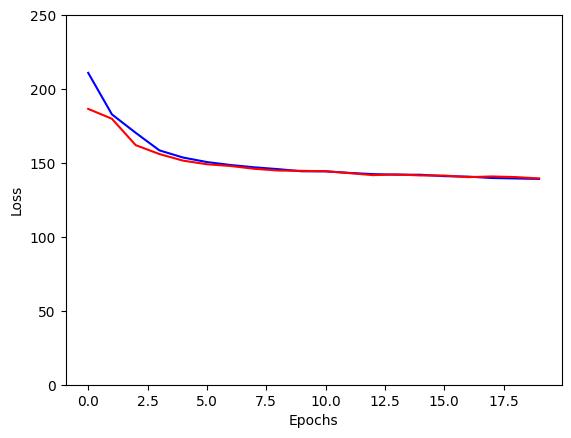

In [6]:
#################### Model Training/Tunning Loss ###############
#################### Model Training/Tunning Loss ###############
plt.figure()
plt.plot(history.history['loss'], c = 'b')
plt.plot(history.history['val_loss'], c = 'r')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.ylim([0,250])

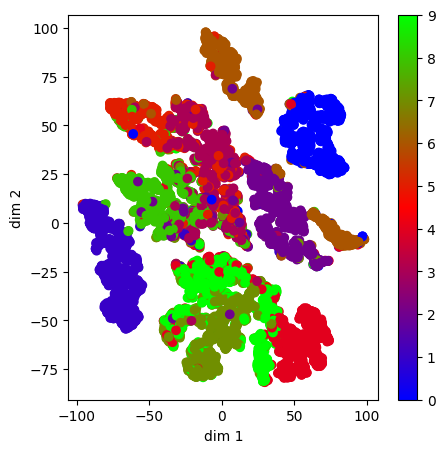

In [8]:
################# Model Predictions ############
################# Model Predictions ############
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
mu, sigma, z = encoder.predict(x_test)
scaler = StandardScaler()
z_scaled = scaler.fit_transform(z)
tsne = TSNE(n_components=2, random_state=42)
z_tsne = tsne.fit_transform(z_scaled)
plt.figure(figsize=(5, 5))
plt.scatter(z_tsne[:, 0], z_tsne[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

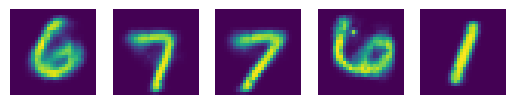

In [9]:
#sample predictions
for i in range(5):
    sample_vector = np.array(np.random.randn(1,latent_dim))
    decoded_example = decoder.predict(sample_vector)
    decoded_example_reshaped = decoded_example.reshape(28, 28)
    plt.subplot(1,5,i+1)
    plt.imshow(decoded_example_reshaped)
    plt.axis('off')

(-0.5, 559.5, 559.5, -0.5)

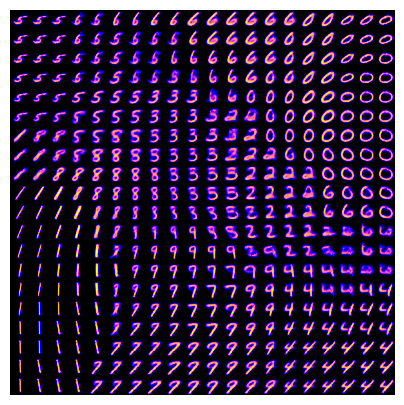

In [10]:
n = 20  # generate 15x15 digits
figure = np.zeros((28 * n, 28 * n, 1))
#Create a Grid of latent variables, to be provided as inputs to decoder.predict
#Creating vectors within range -5 to 5 as that seems to be the range in latent space
grid_x = np.linspace(-100, 100, n)
grid_y = np.linspace(-100, 100, n)[::-1]
# decoder for each square in the grid
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        distances = np.linalg.norm(z_tsne - z_sample, axis=1)        
        closest_index = np.argmin(distances) 
        x_decoded = decoder.predict(np.expand_dims(z[closest_index,:],axis = 0))
        # x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(28, 28, 1)
        figure[i * 28: (i + 1) * 28,
               j * 28: (j + 1) * 28] = digit
plt.figure(figsize=(5, 5))
#Reshape for visualization
fig_shape = np.shape(figure)
figure = figure.reshape((fig_shape[0], fig_shape[1]))
plt.imshow(figure, cmap='gnuplot2')
plt.axis('off')